## Repeat Huang's calculations of satellite fractions

In [1]:
# Imports, and settings
import os,copy,sys,pdb
import numpy as np 
from __future__ import division

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column, vstack, unique
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
astropy_cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

from colossus.halo import mass_so
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 70.0, 'Om0': 0.30, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
colossus_cosmo = cosmology.setCosmology('FlatLambdaCDM', params)
from colossus.halo import profile_nfw

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline 
plt.rc('text', usetex=True)

import linetools.utils as ltu

In [2]:
def find_satellite_single(idx, catalog, mass_col='logm_max', idx_col='idx_ori',
                          ra_col='ra', dec_col='dec', flag_col='flag_satellite',
                          z_col='z_best', r_col='r200m_deg',mh_col='logmh_host'):
    """Find the satellite of a single object in a catalog."""
    # Isolate the target galaxy
    obj = catalog[idx]

    # Only use the ones that are less massive, and are not already identified 
    # as satellite 
    
    # Make a deepcopy, so won't affect the original catalog
    cat_use = copy.deepcopy(catalog[(catalog[mass_col] < obj[mass_col]) & 
                                    (~catalog[flag_col])])

    # First select the ones within the redshift boundary 
    # This will reduce the number of galaxies we need to calculate angular distance for
    # Assume dark matter halo follows NFW profile with concentration parameter = 5
    cvir = 5.
    littleh = astropy_cosmo.H0.value/100.
    p_nfw = profile_nfw.NFWProfile(M=10**obj[mh_col]*littleh,c=cvir,z=obj[z_col],mdef='200m')
    # Assume maximum circular velocity is 1.4 times the lD velocity dispersion in the halo, 
    # following Tormen+97.
    # Set the Delta z cut to be 3 times the 1D dispersion. 
    v_lim = p_nfw.Vmax()[0]/1.4*3
    # Convert velocity cut to redshift cut
    z_lim = ltu.dz_from_dv(v_lim*u.km/u.s,obj[z_col])
    cat_zlim = cat_use[np.abs(cat_use[z_col] - obj[z_col]) <= z_lim]

    if len(cat_zlim) > 0:
        # Make the angular distance cut
        cat_sat = cat_zlim[(SkyCoord(obj[ra_col]*u.deg,obj[dec_col]*u.deg).separation(
                SkyCoord(cat_zlim[ra_col]*u.deg,cat_zlim[dec_col]*u.deg))).deg <= obj[r_col]]
        catalog[flag_col][cat_sat[idx_col]] = True
        return cat_sat
    
    # Just a trick to return an empty table 
    return cat_use[cat_use[z_col] < 0]


def find_satellite_catalog(input_table, sort_col='logm_max', idx_col='idx_ori',
                           ra_col='ra', dec_col='dec', flag_col='flag_satellite',
                           z_col='z_best', r_col='r200m_deg',mh_col='logmh_host'):
    """Identify the satellite galaxies in the catalog."""
    # Sort catalog based on stellar mass 
    catalog = copy.deepcopy(input_table)
    catalog.sort(sort_col)

    # Reverse the order, so the most massive one is at the top
    catalog.reverse()

    # Add an original index array 
    catalog.add_column(Column(data=np.arange(len(catalog)), 
                              name=idx_col))

    # Add a flag array 
    catalog.add_column(Column(data=np.full(len(catalog), 0).astype(bool), 
                              name=flag_col))
    
    # Find the satellite galaxy for each object
    cat_sat = [find_satellite_single(idx, catalog, mass_col=sort_col,
                                     ra_col=ra_col, dec_col=dec_col,
                                     flag_col=flag_col, z_col=z_col,
                                     idx_col=idx_col,
                                     r_col=r_col,
                                     mh_col=mh_col) for idx in np.arange(len(catalog))]
    
    # Merge the catalogs for satellites
    cat_sat = vstack(cat_sat)
    cat_sat = unique(cat_sat)
    
    return catalog, cat_sat

In [3]:
# Load the HSC catalog
hsc_cat = 's16a_massive_logmMax_11.45_z_0.25_0.47_mhalo.fits'
hsc_data = Table.read(os.path.join('../data',hsc_cat))
hsc_data

object_id,ra,dec,z_spec,z_best,z_phot,z_type,gcmodel_mag,gcmodel_mag_err,rcmodel_mag,rcmodel_mag_err,icmodel_mag,icmodel_mag_err,zcmodel_mag,zcmodel_mag_err,ycmodel_mag,ycmodel_mag_err,MSTAR,logm_10,logm_30,logm_100,logm_max,vdisp_sdss,vdisp_err_sdss,logms_gama,logms_err_gama,id_cluster_redm,p_mem_redm,z_lambda_redm,lambda_redm,p_cen_1_redm,id_camira,z_camira,n_cor_camira,logms_camira,r50_max,r50_100,logmh_peak,logmh_vir,logmh_host
int64,float64,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64
39622434810257696,37.3240577564,-2.06572611965,nan,0.25,0.25,6,19.1254,0.00123258,17.7626,0.000521606,17.219,0.000391289,16.8931,0.000438603,16.742,0.000571637,11.5968875885,11.417938992,11.5859992646,11.6602283965,11.6680126428,nan,nan,nan,nan,-9999,nan,nan,nan,nan,-9999,nan,nan,nan,7.94836833645,7.70130678382,13.196176185,13.196176185,13.196176185
40981272268396388,136.747577102,-1.43416980767,0.250189989805,0.250189989805,nan,3,19.7024,0.00160136,18.3259,0.00085849,17.7609,0.000516431,17.439,0.000742912,17.2545,0.00106547,11.4055519104,11.2490506654,11.4769263833,11.5688587088,11.5689686174,nan,nan,nan,nan,-9999,nan,nan,nan,nan,-9999,nan,nan,nan,10.6423923863,10.6385660755,13.996424104,13.9821807456,13.9821807456
69617666066768181,239.968837266,42.6959122769,0.250290006399,0.250290006399,nan,1,19.2602,0.00120491,17.8509,0.000546734,17.273,0.000333689,16.9812,0.000477705,16.7743,0.000809582,11.604549408,11.3580643851,11.5566859927,11.6080984077,11.6080984077,242.874526978,29.4396820068,nan,nan,-9999,nan,nan,nan,nan,-9999,nan,nan,nan,8.2345687606,8.2345687606,13.1766699327,13.1740598077,13.1740598077
41584100993172458,339.302210498,-0.504793979874,0.250330001116,0.250330001116,nan,1,19.5988,0.00113926,18.2364,0.000536785,17.667,0.000477764,17.3642,0.000528524,17.1729,0.000722213,11.4135742188,11.2882856959,11.4499098899,11.5124344518,11.5152383778,239.675521851,19.472776413,nan,nan,-9999,nan,nan,nan,nan,-9999,nan,nan,nan,6.95413889116,6.86718900076,12.7366354977,12.7366354977,12.7366354977
70408610064137875,244.639701888,43.5674369418,0.250389993191,0.250389993191,nan,1,19.6523,0.00135732,18.3068,0.000587538,17.7463,0.000372543,17.4794,0.000560036,17.2799,0.000889238,11.3606510162,11.2195210487,11.3889424337,11.4513140125,11.4513140125,177.904983521,10.5534725189,nan,nan,-9999,nan,nan,nan,nan,-9999,nan,nan,nan,7.65196462775,7.65196462775,12.7251763014,12.7251763014,12.7251763014
41109674610681824,178.578997548,-0.0518349032501,0.250629991293,0.250629991293,nan,3,19.6035,0.00135214,18.1926,0.000601093,17.6369,0.000393528,17.3412,0.000578184,17.1337,0.00079293,11.4521570206,11.263916771,11.4990492131,11.601975995,11.6194221238,275.746795654,16.8607978821,11.3855839116,0.115080090907,21778,0.702241122723,nan,nan,nan,-9999,nan,nan,nan,12.3113975323,11.4853404216,13.5265977091,13.5265977091,13.5265977091
69630181601471641,247.103906888,43.1194526729,0.250640004873,0.250640004873,nan,1,18.9616,0.000926844,17.5717,0.000440862,17.0047,0.000318117,16.7328,0.000424359,16.5344,0.000629445,11.6927719116,11.471283637,11.6853922263,11.7652086048,11.7652086048,259.010498047,15.8575258255,nan,nan,-9999,nan,nan,nan,nan,4361,0.246000006795,12.6759996414,12.2279996872,9.71966684454,9.71966684454,13.426673888,13.3852486824,13.3852486824
70409155524978684,243.443976581,43.2683869117,0.250649988651,0.250649988651,nan,1,19.1986,0.0012693,17.7907,0.000579721,17.2519,0.000486602,16.9256,0.000624257,16.7318,0.00119312,11.5835638046,11.2558815892,11.5821123478,11.7610047555,11.7862523375,264.063781738,22.8199157715,nan,nan,5629,1.0,0.246633663774,38.7823562622,0.933170735836,4216,0.24809999764,32.8359985352,12.5120000839,20.4973699824,18.767863594,14.1544239731,14.1525940779,14.1525940779
69626324720843995,244.11512701

In [4]:
# Apply mass cut and photz cut
select = (hsc_data['z_best'] <= 0.45) & (hsc_data['logm_100'] >= 11.5) 
hsc_data_cut = hsc_data[select]
hsc_data_cut

object_id,ra,dec,z_spec,z_best,z_phot,z_type,gcmodel_mag,gcmodel_mag_err,rcmodel_mag,rcmodel_mag_err,icmodel_mag,icmodel_mag_err,zcmodel_mag,zcmodel_mag_err,ycmodel_mag,ycmodel_mag_err,MSTAR,logm_10,logm_30,logm_100,logm_max,vdisp_sdss,vdisp_err_sdss,logms_gama,logms_err_gama,id_cluster_redm,p_mem_redm,z_lambda_redm,lambda_redm,p_cen_1_redm,id_camira,z_camira,n_cor_camira,logms_camira,r50_max,r50_100,logmh_peak,logmh_vir,logmh_host
int64,float64,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64
39622434810257696,37.3240577564,-2.06572611965,nan,0.25,0.25,6,19.1254,0.00123258,17.7626,0.000521606,17.219,0.000391289,16.8931,0.000438603,16.742,0.000571637,11.5968875885,11.417938992,11.5859992646,11.6602283965,11.6680126428,nan,nan,nan,nan,-9999,nan,nan,nan,nan,-9999,nan,nan,nan,7.94836833645,7.70130678382,13.196176185,13.196176185,13.196176185
40981272268396388,136.747577102,-1.43416980767,0.250189989805,0.250189989805,nan,3,19.7024,0.00160136,18.3259,0.00085849,17.7609,0.000516431,17.439,0.000742912,17.2545,0.00106547,11.4055519104,11.2490506654,11.4769263833,11.5688587088,11.5689686174,nan,nan,nan,nan,-9999,nan,nan,nan,nan,-9999,nan,nan,nan,10.6423923863,10.6385660755,13.996424104,13.9821807456,13.9821807456
69617666066768181,239.968837266,42.6959122769,0.250290006399,0.250290006399,nan,1,19.2602,0.00120491,17.8509,0.000546734,17.273,0.000333689,16.9812,0.000477705,16.7743,0.000809582,11.604549408,11.3580643851,11.5566859927,11.6080984077,11.6080984077,242.874526978,29.4396820068,nan,nan,-9999,nan,nan,nan,nan,-9999,nan,nan,nan,8.2345687606,8.2345687606,13.1766699327,13.1740598077,13.1740598077
41584100993172458,339.302210498,-0.504793979874,0.250330001116,0.250330001116,nan,1,19.5988,0.00113926,18.2364,0.000536785,17.667,0.000477764,17.3642,0.000528524,17.1729,0.000722213,11.4135742188,11.2882856959,11.4499098899,11.5124344518,11.5152383778,239.675521851,19.472776413,nan,nan,-9999,nan,nan,nan,nan,-9999,nan,nan,nan,6.95413889116,6.86718900076,12.7366354977,12.7366354977,12.7366354977
41109674610681824,178.578997548,-0.0518349032501,0.250629991293,0.250629991293,nan,3,19.6035,0.00135214,18.1926,0.000601093,17.6369,0.000393528,17.3412,0.000578184,17.1337,0.00079293,11.4521570206,11.263916771,11.4990492131,11.601975995,11.6194221238,275.746795654,16.8607978821,11.3855839116,0.115080090907,21778,0.702241122723,nan,nan,nan,-9999,nan,nan,nan,12.3113975323,11.4853404216,13.5265977091,13.5265977091,13.5265977091
69630181601471641,247.103906888,43.1194526729,0.250640004873,0.250640004873,nan,1,18.9616,0.000926844,17.5717,0.000440862,17.0047,0.000318117,16.7328,0.000424359,16.5344,0.000629445,11.6927719116,11.471283637,11.6853922263,11.7652086048,11.7652086048,259.010498047,15.8575258255,nan,nan,-9999,nan,nan,nan,nan,4361,0.246000006795,12.6759996414,12.2279996872,9.71966684454,9.71966684454,13.426673888,13.3852486824,13.3852486824
70409155524978684,243.443976581,43.2683869117,0.250649988651,0.250649988651,nan,1,19.1986,0.0012693,17.7907,0.000579721,17.2519,0.000486602,16.9256,0.000624257,16.7318,0.00119312,11.5835638046,11.2558815892,11.5821123478,11.7610047555,11.7862523375,264.063781738,22.8199157715,nan,nan,5629,1.0,0.246633663774,38.7823562622,0.933170735836,4216,0.24809999764,32.8359985352,12.5120000839,20.4973699824,18.767863594,14.1544239731,14.1525940779,14.1525940779
69626324720843995,244.115127018,42.7909957846,0.25069001317,0.25069001317,nan,1,19.4325,0.00126212,18.1042,0.00068423,17.5573,0.000438217,17.2746,0.000675353,17.1161,0.00104572,11.4289398193,11.2297690908,11.4382896291,11.5298435511,11.5381891031,221.532440186,12.9532365799,nan,nan,-9999,nan,nan,nan,nan,-9999,nan,nan,nan,10.3205059997,9.96026801551,13.4885507165,13.475816413,13.475816413
70409426107919885,243.171912865,43.1

In [5]:
# Virial mass input should be in units of M_sun/h; virial radius output is in unit of physical kpc/h
littleh = astropy_cosmo.H0.value/100.
r200m = mass_so.M_to_R(10.0**hsc_data_cut['logmh_host']*littleh,hsc_data_cut['z_best'],'200m')*u.kpc/littleh
# in unit of deg
r200m_deg = (r200m*astropy_cosmo.arcsec_per_kpc_proper(hsc_data_cut['z_best'])).to(u.deg)
hsc_data_cut.add_column(Column(data=r200m,name='r200m'))
hsc_data_cut.add_column(Column(data=r200m_deg,name='r200m_deg'))

In [6]:
# This step takes several minutes
hsc_new, hsc_sat = find_satellite_catalog(hsc_data_cut)

(375, 37)


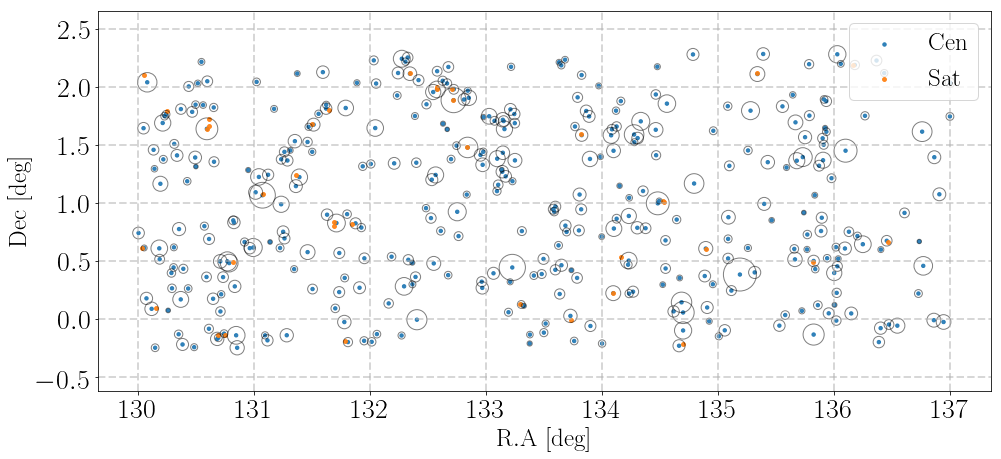

In [7]:
#G09H 

G09H_mask = ((hsc_new['ra'] >= 130.0) & (hsc_new['ra'] <=137.0) & 
             (hsc_new['dec'] >= -0.25) & (hsc_new['dec'] <=2.30)) 
G09H_cen_mask = (G09H_mask & (~hsc_new['flag_satellite']))
G09H_sat_mask = (G09H_mask & (hsc_new['flag_satellite']))
print(sum(G09H_cen_mask), sum(G09H_sat_mask))

G09H_cen = hsc_new[G09H_cen_mask]
G09H_sat = hsc_new[G09H_sat_mask]

fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=2, linestyle='--', alpha=0.5)
ax1.axis('equal')

ax1.scatter(G09H_cen['ra'], G09H_cen['dec'], s=G09H_cen['logm_max'], 
            alpha=0.9, label=r'$\mathrm{Cen}$')

ax1.scatter(G09H_sat['ra'], G09H_sat['dec'], s=15, 
            alpha=0.9, label=r'$\mathrm{Sat}$')

for obj in G09H_cen:
    ax1.add_patch(Circle((obj['ra'], obj['dec']), obj['r200m_deg'], 
                         fill=False, alpha=0.5))
    
ax1.legend(fontsize=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(28) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(28)

_ = ax1.set_xlabel(r'$\mathrm{R.A\ [deg]}$', fontsize=25)
_ = ax1.set_ylabel(r'$\mathrm{Dec\ [deg]}$', fontsize=25)

(132, 10)


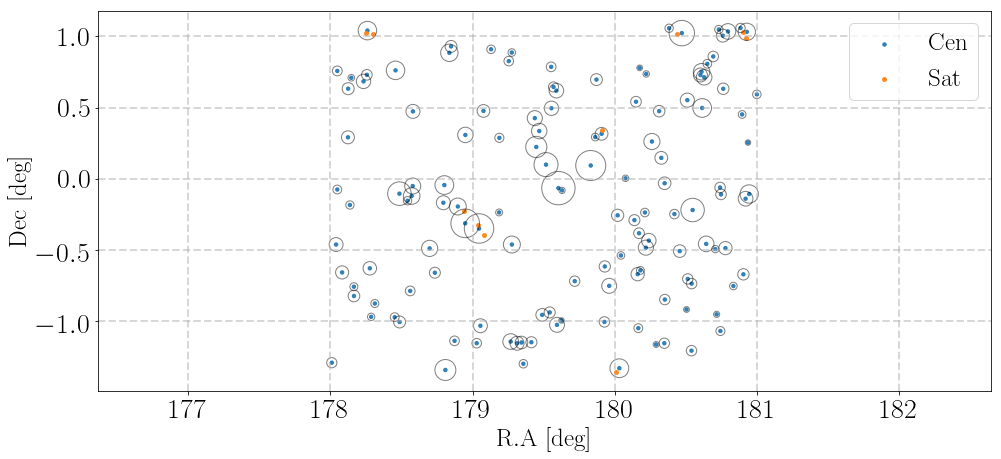

In [16]:
#G12H 

G12H_mask = ((hsc_new['ra'] >= 178.0) & (hsc_new['ra'] <= 181.0) & 
             (hsc_new['dec'] >= -1.38) & (hsc_new['dec'] <= 1.21)) 
G12H_cen_mask = (G12H_mask & (~hsc_new['flag_satellite']))
G12H_sat_mask = (G12H_mask & (hsc_new['flag_satellite']))
print(sum(G12H_cen_mask), sum(G12H_sat_mask))

G12H_cen = hsc_new[G12H_cen_mask]
G12H_sat = hsc_new[G12H_sat_mask]

fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=2, linestyle='--', alpha=0.5)
ax1.axis('equal')

ax1.scatter(G12H_cen['ra'], G12H_cen['dec'], s=G12H_cen['logm_max'], 
            alpha=0.9, label=r'$\mathrm{Cen}$')

ax1.scatter(G12H_sat['ra'], G12H_sat['dec'], s=15, 
            alpha=0.9, label=r'$\mathrm{Sat}$')

for obj in G12H_cen:
    ax1.add_patch(Circle((obj['ra'], obj['dec']), obj['r200m_deg'], 
                         fill=False, alpha=0.5))
    
ax1.legend(fontsize=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(28) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(28)

_ = ax1.set_xlabel(r'$\mathrm{R.A\ [deg]}$', fontsize=25)
_ = ax1.set_ylabel(r'$\mathrm{Dec\ [deg]}$', fontsize=25)

(220, 22)


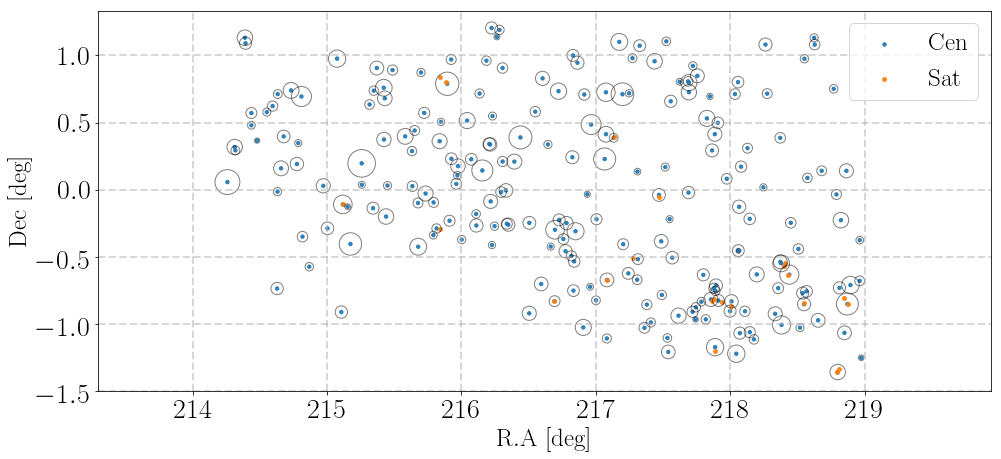

In [17]:
# G15H

G15H_mask = ((hsc_new['ra'] >= 214.0) & (hsc_new['ra'] <= 219.0) & 
             (hsc_new['dec'] >= -1.38) & (hsc_new['dec'] <= 1.21)) 
G15H_cen_mask = (G15H_mask & (~hsc_new['flag_satellite']))
G15H_sat_mask = (G15H_mask & (hsc_new['flag_satellite']))
print(sum(G15H_cen_mask), sum(G15H_sat_mask))

G15H_cen = hsc_new[G15H_cen_mask]
G15H_sat = hsc_new[G15H_sat_mask]

fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=2, linestyle='--', alpha=0.5)
ax1.axis('equal')

ax1.scatter(G15H_cen['ra'], G15H_cen['dec'], s=G15H_cen['logm_max'], 
            alpha=0.9, label=r'$\mathrm{Cen}$')

ax1.scatter(G15H_sat['ra'], G15H_sat['dec'], s=15, 
            alpha=0.9, label=r'$\mathrm{Sat}$')

for obj in G15H_cen:
    ax1.add_patch(Circle((obj['ra'], obj['dec']), obj['r200m_deg'], 
                         fill=False, alpha=0.5))
    
ax1.legend(fontsize=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(28) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(28)

_ = ax1.set_xlabel(r'$\mathrm{R.A\ [deg]}$', fontsize=25)
_ = ax1.set_ylabel(r'$\mathrm{Dec\ [deg]}$', fontsize=25)

(57, 3)


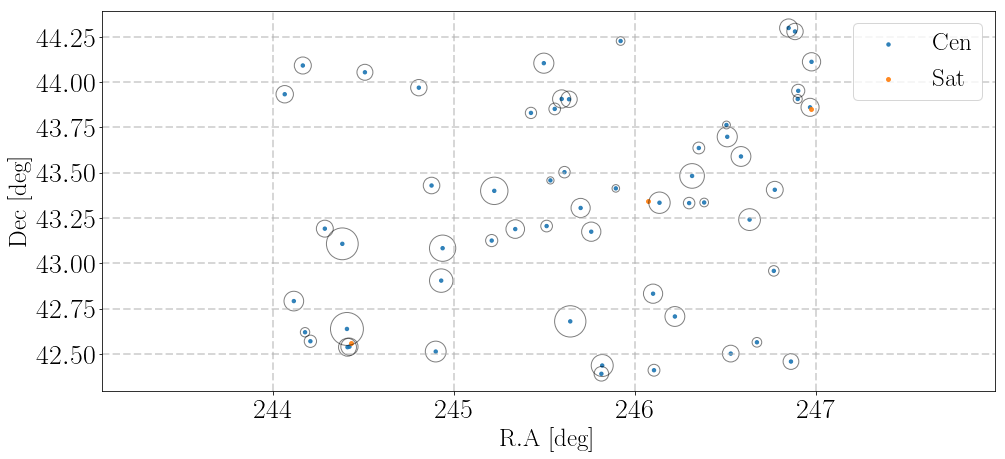

In [19]:
# HectoMap

HectoMap_mask = ((hsc_new['ra'] >= 244.0) & (hsc_new['ra'] <= 247.0) & 
             (hsc_new['dec'] >= 42.3) & (hsc_new['dec'] <= 44.3)) 
HectoMap_cen_mask = (HectoMap_mask & (~hsc_new['flag_satellite']))
HectoMap_sat_mask = (HectoMap_mask & (hsc_new['flag_satellite']))
print(sum(HectoMap_cen_mask), sum(HectoMap_sat_mask))

HectoMap_cen = hsc_new[HectoMap_cen_mask]
HectoMap_sat = hsc_new[HectoMap_sat_mask]

fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=2, linestyle='--', alpha=0.5)
ax1.axis('equal')

ax1.scatter(HectoMap_cen['ra'], HectoMap_cen['dec'], s=HectoMap_cen['logm_max'], 
            alpha=0.9, label=r'$\mathrm{Cen}$')

ax1.scatter(HectoMap_sat['ra'], HectoMap_sat['dec'], s=15, 
            alpha=0.9, label=r'$\mathrm{Sat}$')

for obj in HectoMap_cen:
    ax1.add_patch(Circle((obj['ra'], obj['dec']), obj['r200m_deg'], 
                         fill=False, alpha=0.5))
    
ax1.legend(fontsize=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(28) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(28)

_ = ax1.set_xlabel(r'$\mathrm{R.A\ [deg]}$', fontsize=25)
_ = ax1.set_ylabel(r'$\mathrm{Dec\ [deg]}$', fontsize=25)

In [20]:
# PDR masks
#PDR_mask = G09H_mask | G12H_mask | G15H_mask | HectoMap_mask
#PDR_cen_mask = (PDR_mask & (~hsc_new['flag_satellite']))
#PDR_sat_mask = (PDR_mask & (hsc_new['flag_satellite']))
PDR_cen_mask = G09H_cen_mask | G12H_cen_mask | G15H_cen_mask | HectoMap_cen_mask
PDR_sat_mask = G09H_sat_mask | G12H_sat_mask | G15H_sat_mask | HectoMap_sat_mask

hsc_cen = hsc_new[PDR_cen_mask]
hsc_sat = hsc_new[PDR_sat_mask]

hist_cen, edges_cen = np.histogram(hsc_cen['logm_max'], range=(11.5, 12.10),
                                   bins=6)

hist_sat, edges_sat = np.histogram(hsc_sat['logm_max'], range=(11.5, 12.10),
                                   bins=6)

mass_center = (edges_cen[1:] + edges_cen[:-1]) / 2

frac_sat = (hist_sat / hist_cen) * 100.0

frac_sat_err = (np.sqrt(hist_sat) / hist_cen) * 100.0

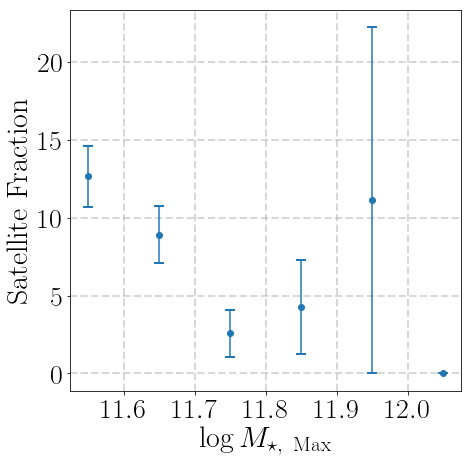

In [21]:
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=2, linestyle='--', alpha=0.5)

ax1.errorbar(mass_center, frac_sat, yerr=frac_sat_err, fmt='o',
             capthick=2, capsize=5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(28) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(28)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=30)
_ = ax1.set_ylabel(r'$\mathrm{Satellite\ Fraction}$', fontsize=30)